In [2]:
import pandas as pd
from datetime import datetime
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import time
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import cPickle
CSV_PATH='/home/kvassay/data/book-recommender/ratings_Books.csv'
QUESTIONS_PATH='/home/kvassay/data/book-recommender/questions.txt'
MODELS_FOLDER='/home/kvassay/data/book-recommender/models_no_dev/'
BEST_CFG_PATH='/home/kvassay/data/book-recommender/best_cfg.dump'
%matplotlib inline

In [3]:
import logging
logger = logging.getLogger()
logger.setLevel('INFO')
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(ch)
logger.info('Logger works.') #to prevent duplicate logs

2016-12-14 14:32:34,875 - root - INFO - Logger works.


### Reading and sorting data

In [4]:
raw_data=pd.read_csv(CSV_PATH,header=0,names=['user','item','rating','timestamp'])

### Dumping data < 2013.

In [5]:
raw_data=raw_data[raw_data['timestamp']>1356998400]

### Extract user-item impressions dict

In [6]:
def split(raw_data, quantile=0.7):
    q=raw_data['timestamp'].quantile(quantile)
    return raw_data[raw_data['timestamp']<=q], raw_data[raw_data['timestamp']>q]

def get_user_items_dict(data, min_ratings, max_ratings):
    user_item_dict=dict()
    for row in data.itertuples():
        if row.user in user_item_dict:
            user_item_dict[row.user].append(row.item)
        else:
            user_item_dict[row.user]=[row.item]
    user_item_dict_clean={key: value for key,value in user_item_dict.iteritems() if len(value)>=min_ratings and len(value)<max_ratings}
    return user_item_dict_clean

def get_user_items_list_lengths(user_item_dict):
    return pd.DataFrame(sorted([len(item_list) for _,item_list in user_item_dict.iteritems()]))
    

def remove_users_not_in_train(train_dict, other_dict):
    #intersection=set(other_dict.keys()) & set(train_dict.keys())
    #n_intersection=len(intersection)
    #new_dict={key: other_dict[key] for key in intersection}
    #len_before=len(other_dict)
    #n_removed = len_before - len(new_dict)
    #logger.info('Removed %s users which weren\'t in the training set. Intersection cardinality: %s...', n_removed, n_intersection)
    keys=other_dict.keys()
    for key in keys:
        if not key in train_dict:
            del other_dict[key]
    return other_dict

### Train-test split

In [7]:
raw_train, raw_test = split(raw_data)

In [8]:
user_item_train = get_user_items_dict(raw_train, min_ratings=10, max_ratings=100)
user_item_test = get_user_items_dict(raw_test, min_ratings=1, max_ratings=100)
user_item_test = remove_users_not_in_train(user_item_train, user_item_test)

### Training dataset Analysis

#### User count

In [9]:
len(user_item_train.keys())

94722

#### Item count distribution per user

In [10]:
item_counts_train=get_user_items_list_lengths(user_item_train)
item_counts_test=get_user_items_list_lengths(user_item_test)

In [11]:
item_counts_train.describe()

,0
count,94722.000000
mean,20.397173
std,14.792865
min,10.000000
25%,11.000000
50%,15.000000
75%,23.000000
max,99.000000


In [12]:
item_counts_test.describe()

,0
count,66877.000000
mean,8.005742
std,10.458562
min,1.000000
25%,2.000000
50%,4.000000
75%,10.000000
max,99.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe678c08c10>]], dtype=object)

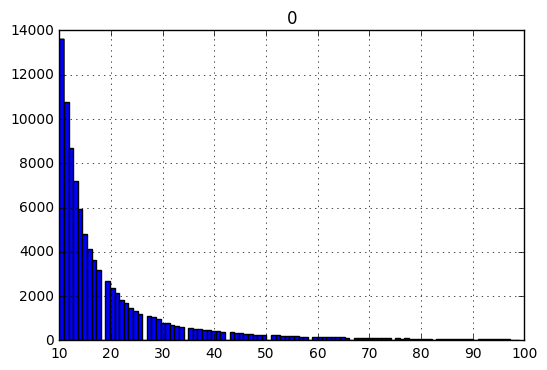

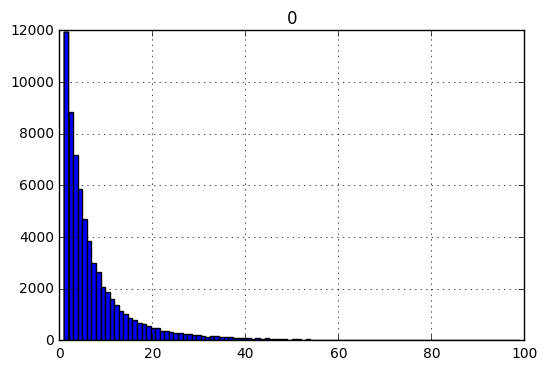

In [13]:
nbins=100
item_counts_train.hist(bins=nbins)
item_counts_test.hist(bins=nbins)

### Limiting dataset sizes

Especially evaluations take a lot of time, limiting dataset sizes might be useful.

In [14]:
#for testing:
TRAIN_SIZE=100000
TEST_SIZE=1000
'''
In addition to limiting the dataset sizes we need to make sure, 
that all users from DEV and TEST set are present in TRAIN set.
To do that we simply add them to TRAIN set after limiting.
'''
user_item_train_tmp={key: user_item_train[key] for key in user_item_train.keys()[:TRAIN_SIZE]}
user_item_test={key: user_item_test[key] for key in user_item_test.keys()[:TEST_SIZE]}
for usr in user_item_test:
    if usr not in user_item_train_tmp:
        user_item_train_tmp[usr]=user_item_train[usr]
user_item_train=user_item_train_tmp

In [15]:
print([len(user_item_train), len(user_item_test)])

[94722, 1000]


### Training data preparation
For Gensim

In [19]:
train_data=[TaggedDocument([unicode(word) for word in words], [user_id]) for user_id, words in user_item_train.iteritems()]

### Baseline model and evaluation function
Evaluation methods and Baseline model for comparison.

In [20]:
class BaselineModel():
    '''
    Always returns k most frequent items.
    '''
    def __init__(self,train_set,topn=100):
        logger.info('Couting %s most frequent items for BaselineModel...',topn)
        items=list()
        for key in train_set:
            items.extend(train_set[key])
        counter=Counter(items)
        self.result=counter.most_common(topn)
        logger.info('BaselineModel initialized...')
        
    def most_similar(self, positive=None, topn=None):
        #parameters are there just for compatibility with Gensim model evaluator
        return self.result
        
        
def percentage(part, whole):
    return 100 * float(part)/float(whole)

def evaluate_score(model, train_set, test_set, topn=10, limit_users=None):
    '''
    Asks model for k recommendations based on users data in the past (train_set)
    and looks if at least one of them appeared in the future (test_set). In the end
    evaluator returns in how many % cases it did.
    '''
    rec_count=0
    confirmed_match=0
    if limit_users is not None:
        users=test_set.keys()[:limit_users]
        np.random.shuffle(users)
    else:
        users=test_set.keys()
    for user in users:
        train_items=train_set[user]
        test_data=test_set[user]
        recommended=[tupl[0] for tupl in model.most_similar(positive=train_items, topn=topn*10) if tupl[0] not in train_items]
        recommended=recommended[:topn]
        for item in recommended:
            if item in test_data:
                confirmed_match+=1
        rec_count+=topn
    return percentage(confirmed_match,rec_count)
    
    


### Doc2Vec models training

In [29]:
def train(persist=False, decrease_alpha=False):
    '''
    Initializing model
    '''
    logger.info('Initializing model...')
    with open(BEST_CFG_PATH, 'r') as f:
        cfg=cPickle.load(f)
    model = Doc2Vec(alpha=cfg['alpha'], min_alpha=cfg['alpha'], min_count=cfg['min_count'], size=cfg['size'],
                    window=cfg['window'], negative=cfg['negative'])  # use fixed learning rate
    logger.info('Building vocabulary...')
    logger.setLevel(logging.ERROR)
    start=time.time()
    model.build_vocab(train_data)
    dur=time.time()-start
    logger.setLevel(logging.INFO)
    logger.info('Building vocabulary took %s seconds...', dur)
    '''
    Learning model for multiple epochs, after each model is persisted to HDD.
    '''

    start=time.time()
    logger.info('Shuffling training data')
    '''
    Data are shuffled before each iteration to ensure ordering 
    won't corrupt gradient computation and not cause overfitting on some local minima
    '''
    np.random.shuffle(train_data)
    dur=time.time()-start
    logger.info('Shuffling training set took %s seconds...', dur)
    start=time.time()
    model_save_path=MODELS_FOLDER+'doc2vec_model'
    '''
    Training
    '''
    logger.info('Training...')
    model.train(train_data)
    if persist:
        '''
        Persisting
        '''
        model.save(model_save_path)
    if decrease_alpha:
        model.alpha -= 0.0005  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay
    logger.setLevel(logging.INFO)
    dur=time.time()-start
    logger.info('Training model took %s seconds...', dur)
    return model

In [30]:
logger.setLevel(logging.INFO)
train(persist=True, decrease_alpha=False)

2016-12-14 14:42:42,826 - root - INFO - Initializing model...
2016-12-14 14:42:42,828 - root - INFO - Building vocabulary...
2016-12-14 14:43:16,796 - root - INFO - Building vocabulary took 33.9662659168 seconds...
2016-12-14 14:43:16,797 - root - INFO - Shuffling training data
2016-12-14 14:43:16,807 - root - INFO - Shuffling training set took 0.00956010818481 seconds...
2016-12-14 14:43:16,808 - root - INFO - Training...
2016-12-14 14:43:16,809 - gensim.models.word2vec - INFO - training model with 1 workers on 463078 vocabulary and 300 features, using sg=0 hs=1 sample=0 negative=5
2016-12-14 14:43:16,809 - gensim.models.word2vec - INFO - expecting 94722 sentences, matching count from corpus used for vocabulary survey
2016-12-14 14:43:17,963 - gensim.models.word2vec - INFO - PROGRESS: at 0.21% examples, 18193 words/s, in_qsize 2, out_qsize 0
2016-12-14 14:43:19,056 - gensim.models.word2vec - INFO - PROGRESS: at 0.82% examples, 37329 words/s, in_qsize 1, out_qsize 0
2016-12-14 14:43:20

### Doc2Vec model evaluation

In [36]:
logger.setLevel(logging.INFO)
baseline_model=BaselineModel(user_item_train)
model_path=MODELS_FOLDER+'doc2vec_model'
logger.info('Computing scores...')
scores_test=list()
scores_baseline_test=list()
logger.info('Loading model...')
start=time.time()
logger.setLevel(logging.ERROR)
model=Doc2Vec.load(model_path)
dur=time.time()-start
logger.setLevel(logging.INFO)
logger.info('Model loading took %s seconds...', dur)
for i in range(1,11,1):
    start=time.time()
    logger.info('Computing score for banner count %s...',i)
    logger.setLevel(logging.ERROR)
    start=time.time()
    baseline_score=evaluate_score(baseline_model, user_item_train, user_item_test, topn=i)
    score_test=evaluate_score(model, user_item_train, user_item_test,topn=i)
    dur=time.time()-start
    logger.setLevel(logging.INFO)
    logger.info('Computing score took %s seconds...', dur)
    logger.info('Score on test set for banner count %s = %s %%...', i, score_test)
    scores_test.append(score_test)
    scores_baseline_test.append(baseline_score)
    

2016-12-14 15:28:11,714 - root - INFO - Couting 100 most frequent items for BaselineModel...
2016-12-14 15:28:15,740 - root - INFO - BaselineModel initialized...
2016-12-14 15:28:15,779 - root - INFO - Computing scores...
2016-12-14 15:28:15,780 - root - INFO - Loading model...
2016-12-14 15:28:25,798 - root - INFO - Model loading took 10.0164821148 seconds...
2016-12-14 15:28:25,806 - root - INFO - Computing score for banner count 1...
2016-12-14 15:29:10,127 - root - INFO - Computing score took 44.3190608025 seconds...
2016-12-14 15:29:10,130 - root - INFO - Score on test set for banner count 1 = 0.4 %...
2016-12-14 15:29:10,132 - root - INFO - Computing score for banner count 2...
2016-12-14 15:29:56,933 - root - INFO - Computing score took 46.8004169464 seconds...
2016-12-14 15:29:56,944 - root - INFO - Score on test set for banner count 2 = 0.45 %...
2016-12-14 15:29:56,945 - root - INFO - Computing score for banner count 3...
2016-12-14 15:30:39,968 - root - INFO - Computing scor

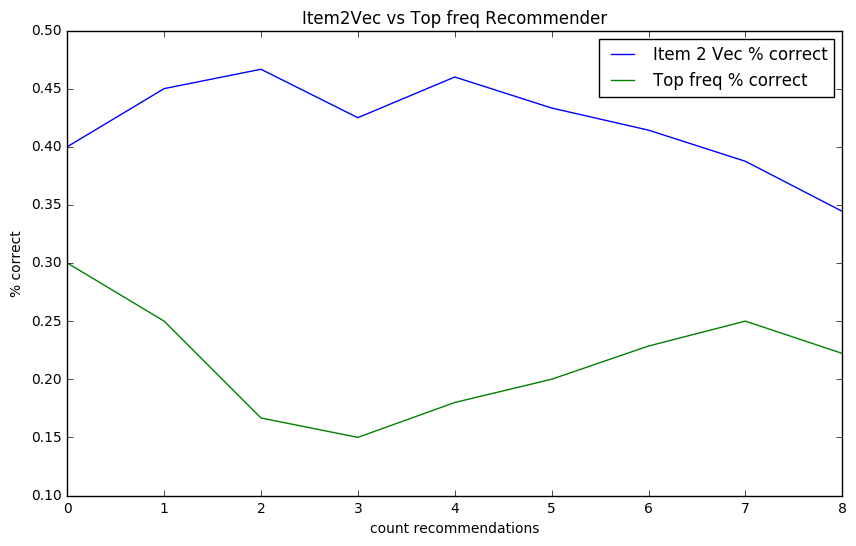

In [46]:
df=pd.DataFrame.from_dict({'Item 2 Vec % correct' : scores_test,
                           'Top freq % correct':scores_baseline_test})
df.plot(figsize=(10,6))
plt.title('Item2Vec vs Top freq Recommender')
plt.xlabel('count recommendations')
plt.ylabel('% correct')

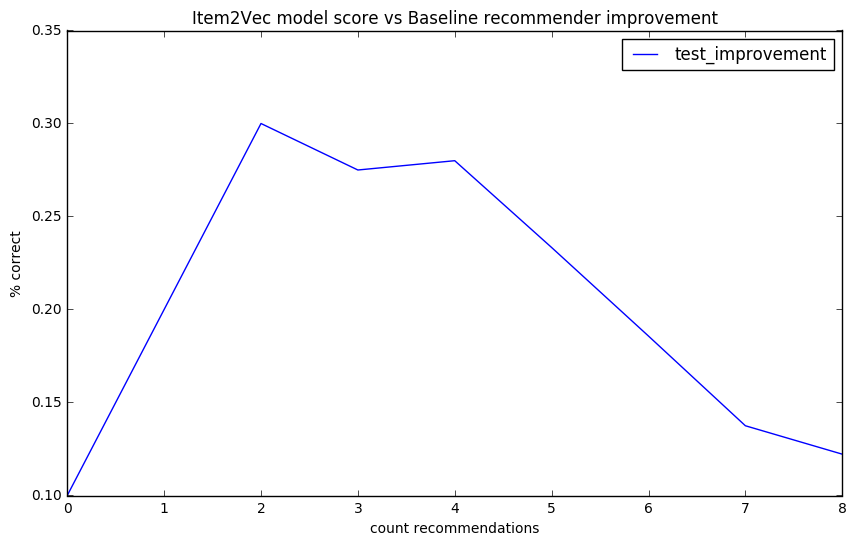

In [48]:
df['test_improvement']=df['Item 2 Vec % correct']-df['Top freq % correct']
df_diffs=df.reindex_axis(['test_improvement'], axis=1)
df_diffs.plot(figsize=(10,6))
plt.title('Item2Vec model score vs Baseline recommender improvement')
plt.xlabel('count recommendations')
plt.ylabel('% correct')